<a href="https://colab.research.google.com/github/quxiaojing1985/mytvmpractice/blob/main/endtoend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python3 -m  pip install mlc-ai-nightly -f https://mlc.ai/wheels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://mlc.ai/wheels
     |████████████████████████████████| 44.2 MB 1.2 MB/s 


In [ ]:
import tvm
from tvm.ir.module import IRModule
from tvm.script import tir as T, relax as R
import numpy as np
from tvm import relax
# This is needed for deferring annotation parsing in TVMScript
from __future__ import annotations 

In [ ]:
import IPython

def code2html(code):
    """Helper function to use pygments to turn the code string into highlighted html."""
    import pygments
    from pygments.lexers import Python3Lexer
    from pygments.formatters import HtmlFormatter
    formatter = HtmlFormatter()
    html = pygments.highlight(code, Python3Lexer(), formatter)
    return "<style>%s</style>%s\n" % (formatter.get_style_defs(".highlight"), html)

In [ ]:
from torchvision.datasets.mnist import FashionMNIST
import torchvision
import torch
test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download = True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
img,label = next(iter(test_loader))
img =  img.reshape(1, 28, 28).numpy()


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



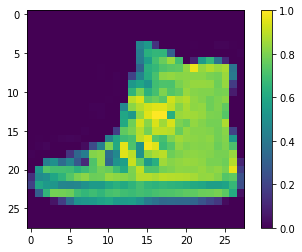

Class: Ankle boot


In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()

print("Class:", class_names[label[0]])

In [ ]:
!wget https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl

--2022-08-10 08:32:29--  https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl [following]
--2022-08-10 08:32:30--  https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407396 (398K) [application/octet-stream]
Saving to: ‘fasionmnist_mlp_params.pkl’

fasionmnist_mlp_par 100%[===================>] 397.85K  --.-KB/s    in 0.02s   

2022-08-10 08:32:30 (17.7 MB/s) - ‘fasionmnist_mlp_params.p

In [ ]:
def numpy_mlp(data, w0, b0, w1, b1):
  lv0 = data @ w0.T + b0
  lv1 = np.maximum(lv0, 0)
  lv2 = lv1 @ w1.T + b1
  return lv2

In [ ]:
import pickle as pkl
mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))
res = numpy_mlp(img.reshape(1, 784),
                mlp_params["w0"],
                mlp_params["b0"],
                mlp_params["w1"],
                mlp_params["b1"])
print(res)
pred_kind =res.argmax(axis=1)
print(pred_kind)
print("Numpy-MLP predictiona:", class_names[pred_kind[0]])

[[-39.875263  -48.9297    -27.68033   -27.276981  -21.989426    1.2821026
  -25.406279   -7.0437164 -12.268626   22.716991 ]]
[9]
Numpy-MLP predictiona: Ankle boot


In [ ]:
def lnumpy_linear0(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z:np.ndarray):
  Y = np.empty((1, 128), dtype = "float32")
  for i in range(1):
    for j in range(128):
      for k in range(784):
        if k == 0:
          Y[i, j] = 0
        Y[i, j] = Y[i, j] + X[i, k]*W[j,k]
  for i in range(1):
    for j in range(128):
      Z[i, j] = Y[i, j] + B[j]
def lnumpy_relu0(X: np.ndarray, Y: np.ndarray):
  for i in range(1):
    for j in range(128):
      Y[i, j] = np.maximum(X[i, j], 0)
def lnumpy_linear1(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z:np.ndarray):
  Y = np.empty((1, 10), dtype = "float32")
  for i in range(1):
    for j in range(10):
      for k in range(128):
        if k == 0:
          Y[i, j] = 0
        Y[i, j] = Y[i, j] + X[i, k]*W[j,k]
  for i in range(1):
    for j in range(10):
      Z[i, j] = Y[i, j] + B[j]

def lnumpy_mlp(data, w0, b0, w1, b1):
  lv0 = np.empty((1, 128), dtype = "float32")
  lnumpy_linear0(data, w0, b0, lv0)

  lv1 = np.empty((1,128), dtype="float32")
  lnumpy_relu0(lv0, lv1)

  out = np.empty((1, 10), dtype = "float32")
  lnumpy_linear1(lv1, w1, b1, out)
  return out
result = lnumpy_mlp(
      img.reshape(1, 784),
      mlp_params["w0"],
      mlp_params["b0"],
      mlp_params["w1"],
      mlp_params["b1"]
  )
pred_kind = result.argmax(axis=1)
print("Low-level Numpy MLP Prediction:", class_names[pred_kind[0]])

Low-level Numpy MLP Prediction: Ankle boot
